In [1]:
import os
from os import listdir, makedirs
from os.path import join, isfile, isdir, splitext
from PIL import Image
import skimage.color as color
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# ILSVRC Data

In [2]:
images_path = './Dataset/ILSVRC2014_train'
filename='ILSVRC2014_train_00000001.JPEG'

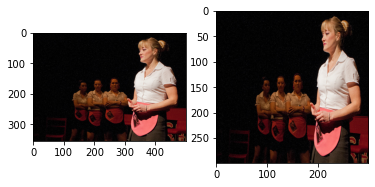

In [3]:
img=Image.open(join(images_path,filename))
f=plt.figure()
f.add_subplot(1,2,1)
plt.imshow(img)
img=img.resize((299,299))
f.add_subplot(1,2,2)
plt.imshow(img)
plt.show()

# Resize all Images to 299x299

In [4]:
from utils.resize import ImageResizer
images_path = './Dataset/ILSVRC2014_train'
print(f'{images_path}')
resized_dir='./Dataset/resized'
size=(299,299)
resizer=ImageResizer(source_dir=images_path,
                    dest_dir=resized_dir).resize_all(size=size)

./Dataset/ILSVRC2014_train


KeyboardInterrupt: 

# Save and load image list

In [5]:
import os

a = open("./Dataset/listjpeg.txt", "w")
for path, subdirs, files in os.walk(r'./Dataset/resized'):
    for filename in files:
        f = os.path.join(filename)
        a.write(str(f) + '\n') 

# Convert to Incep-Resnet-v2 records

In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16629720014377909505
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7152743919396061228
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7041626944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 974716270317415653
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15692147011527683479
physical_device_desc: "device: XLA_GPU device"
]


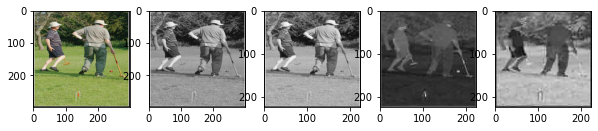

In [5]:
from utils.prep import prep_for_inception, RGB_to_lab
resized_dir='./Dataset/resized'
train1=join(resized_dir,'ILSVRC2014_train_00000002.JPEG')
img1=Image.open(train1)
f=plt.figure(figsize=(10,10))
f.add_subplot(1,5,1)
plt.imshow(img1)
incep_img=prep_for_inception(np.asarray(img1))
f.add_subplot(1,5,2)
plt.imshow(incep_img[0])
l_img,ab_img=RGB_to_lab(np.asarray(img1))
f.add_subplot(1,5,3)
plt.imshow(l_img[0],cmap='gray')
f.add_subplot(1,5,4)
plt.imshow(ab_img[0,:,:,0],cmap='gray')
f.add_subplot(1,5,5)
plt.imshow(ab_img[0,:,:,1],cmap='gray')

In [6]:
from utils.tfrecord_writer import tfrecordwriter
img_list = './Dataset/listjpeg.txt'
resized_dir = './Dataset/resized' 
record_path = './tfrecords/'
file_name = 'ILSVRC2014.tfrecords'
tfrecordwriter(resized_dir, img_list, record_path, file_name)

10000 records wrote
20000 records wrote
30000 records wrote
40000 records wrote
50000 records wrote
60000 records wrote
Successfully write 60610 records, stored at ./tfrecords/ILSVRC2014.tfrecords


# Read From tfrecord

In [2]:
from utils.tfrecord_reader import batch_reader
record_path = './tfrecords/'
record_file = 'ILSVRC2014.tfrecords'
batch_size = 1
train_batch_generator = batch_reader(batch_size, record_path, record_file)

In [3]:
train_batch=next(train_batch_generator)
test_l, test_emb=train_batch[0]
test_ab=train_batch[1]
test_truth=tf.concat([test_l*100,test_ab*127], 3)
test_truth=color.lab2rgb(test_truth)

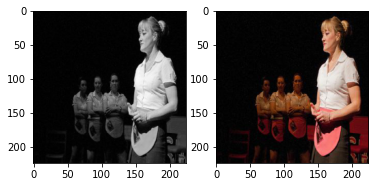

In [4]:
f=plt.figure()
f.add_subplot(1,2,1)
plt.imshow(test_l[0],cmap='gray')
f.add_subplot(1,2,2)
plt.imshow(test_truth[0])
plt.show()

# Train model

In [5]:
from utils.tfrecord_reader import batch_reader
record_path = './tfrecords/'
record_file = 'ILSVRC2014.tfrecords'
batch_size = 100
train_batch_generator=batch_reader(batch_size, record_path, record_file)

In [ ]:
from utils.network import deep_color
history=deep_color.fit(train_batch_generator, epochs=200, steps_per_epoch=30)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 128 73856       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 56, 56, 128)  147584      conv2d_1[0][0]                   
______________________________________________________________________________________________

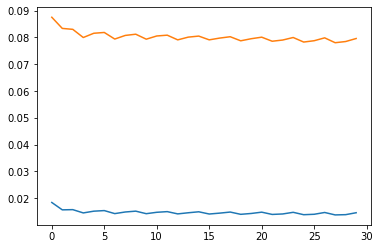

In [8]:
plt.plot(history.history['mse'])
plt.plot(history.history['mae'])

# Get test case

In [9]:
record_path = './tfrecords/'
train_file = 'train.tfrecords'
batch_size = 1 
test_generator=batch_reader(batch_size, record_path, train_file)

In [46]:
test_img=next(test_generator)
test_l, test_emb=test_img[0]
test_ab=test_img[1]

In [47]:
test_pred=deep_color.predict([test_l,test_emb])

In [48]:
test_result=tf.concat([test_l*100,test_pred*127], 3)
test_result=color.lab2rgb(test_result)
test_truth=tf.concat([test_l*100,test_ab*127], 3)
test_truth=color.lab2rgb(test_truth)

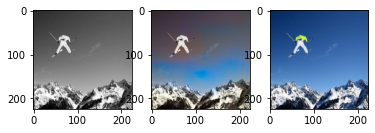

In [49]:
f=plt.figure()
f.add_subplot(1,3,1)
plt.imshow(test_l[0],cmap='gray')
f.add_subplot(1,3,2)
plt.imshow(test_result[0])
f.add_subplot(1,3,3)
plt.imshow(test_truth[0])
plt.show()